# Flashbots Analysis

## Code preamble

In [1]:
from mevlib.utils.utils import connect_to_mongodb
import pandas as pd
from pymongo import ASCENDING, DESCENDING
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pprint import pprint
import matplotlib.dates as mdates
import locale
locale.setlocale(locale.LC_ALL, 'en_US')

'en_US'

Connect to MongoDB and get a connection object for our collection. To run this
against your own MongoDB instance, set the following three environment
variables: MONGODB_ENDPOINT, MONGODB_PASSWORD, MONGODB_USERNAME. For example:
```bash
export MONGODB_ENDPOINT="mongodb://localhost:27017"
export MONGODB_PASSWORD="mypassword"
export MONGODB_USERNAME="root"
```

In [2]:
db = connect_to_mongodb()
confirmed_mevs = db.flashbots.confirmed_mevs

# Analysis

When is our first block from? 

In [3]:
first_block = confirmed_mevs.find().sort("block_number", ASCENDING).limit(1)[0]["block_number"]
print(f"First collected block: {first_block}")

First collected block: 10000071


When was the last block from?

In [4]:
last_block = confirmed_mevs.find().sort("block_number", DESCENDING).limit(1)[0]["block_number"]
print(f"Last collected block: {last_block}")

Last collected block: 13699975


## Useful queries

In [5]:
is_flashbots_query = {"flashbots_bundle": True}
is_non_flashbots_query = {"flashbots_bundle": False}


## When is the first Flashbots block from?

Christof's measurements go back to before Flashbots was operational. This calculation shows the first time the Flashbots API.

In [6]:
first_flashbots_block_raw = confirmed_mevs.find(is_flashbots_query).sort("block_number", ASCENDING).limit(1)[0]
first_flashbots_block = first_flashbots_block_raw["block_number"]

print(f"First Flashbots block: {first_flashbots_block}")

First Flashbots block: 11986936


## Queries that depend on the first block

In [7]:
before_fb_query = {"block_number": {"$lt": first_flashbots_block}}
non_fb_before_query = is_non_flashbots_query | before_fb_query
after_fb_query = {"block_number": {"$gte": first_flashbots_block}}
is_fb_after_fb_query = is_flashbots_query | after_fb_query
non_fb_after_query = is_non_flashbots_query | after_fb_query
unprofitable_tx_query = {"profit_eth": {"$lte": 0}}
unprofitable_fb_query = is_fb_after_fb_query | unprofitable_tx_query


## What proportion of Ethereum transactions went through Flashbots?

How many transactions went through Flashbots during this time span?

In [8]:
flashbots_txs = confirmed_mevs.count_documents(is_flashbots_query)
print(f"Flashbots transactions: {flashbots_txs}")

Flashbots transactions: 410381


How many transactions did not go through Flashbots during this time span?

In [9]:
non_flashbots_txs = confirmed_mevs.count_documents(is_non_flashbots_query)
print(f"Non-Flashbots transactions: {non_flashbots_txs}")

Non-Flashbots transactions: 516402


### Flashbots transactions over full time interval

We start by plotting the ratio of Flashbots transactions to non-Flashbots transactions over the entire time interval.

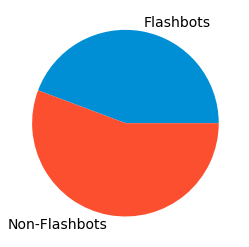

In [10]:
plt.style.use('fivethirtyeight')
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie([flashbots_txs, non_flashbots_txs], labels = ["Flashbots", "Non-Flashbots"])
plt.show() 

We can see that a little less than half of the transactions used flashbots over
the _entire_ time span. However, we must ask what these ratios look like
independently before and after Flashbots started. Really, we can only go back to
when the Flashbots API provides history from, we do not know whether or not that
truly coincides with the start of Flashbots.

### Flashbots transactions before Flashbots started (sanity check, should be zero)

In [11]:
flashbots_txs_before = confirmed_mevs.count_documents(is_flashbots_query | before_fb_query)

non_flashbots_txs_before = confirmed_mevs.count_documents(non_fb_before_query)
total_mev_before_fb = confirmed_mevs.count_documents(before_fb_query)

print(f"Flashbots transactions: {flashbots_txs_before}")
print(f"MEV transactions before Flashbots: {total_mev_before_fb}")
print(f"Non-Flashbots transactions before Flashbots: {non_flashbots_txs_before}")
assert non_flashbots_txs_before == total_mev_before_fb
assert flashbots_txs_before == 0

Flashbots transactions: 0
MEV transactions before Flashbots: 356490
Non-Flashbots transactions before Flashbots: 356490


We see the expected zero Flashbots transactions, which grants us a little more confidence in the data.

### Flashbots transactions *after* Flashbots started

In [12]:
flashbots_txs_after = confirmed_mevs.count_documents(is_fb_after_fb_query)

non_flashbots_txs_after = confirmed_mevs.count_documents(non_fb_after_query)

print(f"Flashbots transactions: {flashbots_txs_after}")
print(f"Non-Flashbots transactions after Flashbots began: {non_flashbots_txs_after}")

Flashbots transactions: 410381
Non-Flashbots transactions after Flashbots began: 159912


We can now plot the ratio of Flashbots transactions to non-Flashbots transactions over *only* the time interval that Flashbots was operational.

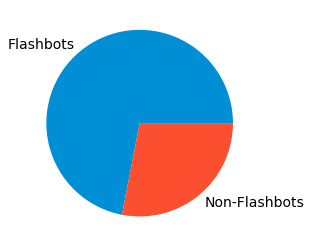

In [13]:
plt.style.use('fivethirtyeight')
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie([flashbots_txs_after, non_flashbots_txs_after], labels = ["Flashbots", "Non-Flashbots"])
plt.show() 

## How have frontrunning profits changed as a result of Flashbots?

### Searcher profits

We compare below the profits that frontrunners were making in the pre-Flashbots days, to their profits since then. This is the average profit per transaction.

In [36]:
def make_pipeline(match_query, group_operation):
    return [
        {
            "$match": match_query
        },
        {
            "$group": group_operation
        }    
    ]

def make_sorted_pipeline(match_query, group_operation, sort_operation):
    return make_pipeline(match_query, group_operation).append(
        {
            "$sort": sort_operation
        })

def make_profit_pipline(match_query):
    sum_profit_operation = {
        "_id": None,
        "profit" : {"$sum": "$profit_eth"}
    }

    return make_pipeline(match_query, sum_profit_operation)


def calculate_profit(match):
    return confirmed_mevs.aggregate(make_profit_pipline(match)).next()["profit"]


before_fb_profit = calculate_profit(non_fb_before_query)
print(f"Total profits before Flashbots began: {before_fb_profit}")

after_fb_profit = calculate_profit(after_fb_query)
print(f"Total profits after Flashbots began: {after_fb_profit}")

before_fb_avg_profit = before_fb_profit / non_flashbots_txs_before
print(f"Average profit (per transaction) before Flashbots began: {before_fb_avg_profit}")

total_txs_after = confirmed_mevs.count_documents(after_fb_query)
after_fb_avg_profit = after_fb_profit / total_txs_after
print(f"Average profit (per transaction) after Flashbots began: {after_fb_avg_profit}")

fb_after_fb_profit = calculate_profit(is_fb_after_fb_query)
fb_avg_profit_after_fb = fb_after_fb_profit / flashbots_txs_after
print(f"Average profit (per transaction) of Flashbots transactsion after Flashbots began: {fb_avg_profit_after_fb}")

non_fb_after_fb_profit = calculate_profit(non_fb_after_query)
non_fb_avg_profit_after_fb = non_fb_after_fb_profit / non_flashbots_txs_after
print(f"Average profit (per transaction) of *non*-Flashbots transactions after Flashbots began: {non_fb_avg_profit_after_fb}")

Total profits before Flashbots began: 50010.40887936719
Total profits after Flashbots began: 27696.3110733925
Average profit (per transaction) before Flashbots began: 0.14028558691510895
Average profit (per transaction) after Flashbots began: 0.048565055284551094
Average profit (per transaction) of Flashbots transactsion after Flashbots began: 0.020530926029875107
Average profit (per transaction) of *non*-Flashbots transactions after Flashbots began: 0.1205088368498069


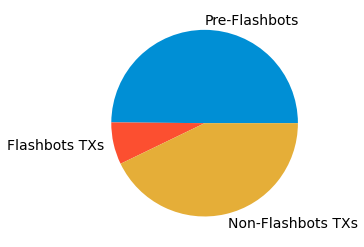

In [15]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

profit_segments = [before_fb_avg_profit, fb_avg_profit_after_fb, non_fb_avg_profit_after_fb]
profit_labels = ["Pre-Flashbots", "Flashbots TXs", "Non-Flashbots TXs"]

ax.pie(profit_segments, labels = profit_labels, normalize=True)
plt.show() 

This shows the ratio of average profits for all pre-Flashbots transactions,
non-Flashbots transactions after Flashbots began, and Flashbots transactions
after Flashbots begain. The interesting thing about this plot is that since
Flashbots began, MEV transactions that have circumvented Flashbots have been
more signifcantly more profitable. However, these profits are only calculated
for searchers.

We can also view the same data in absolute terms.

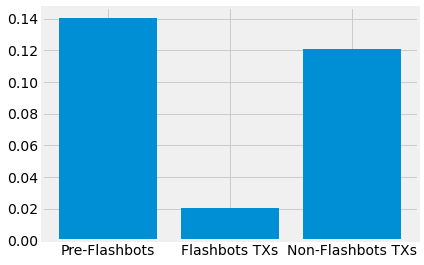

In [16]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

plt.bar(profit_labels, profit_segments)
plt.show() 

We also view these changing profits as a function of time since Flashbots began for both Flashbots and non-Flashbots tranactions.

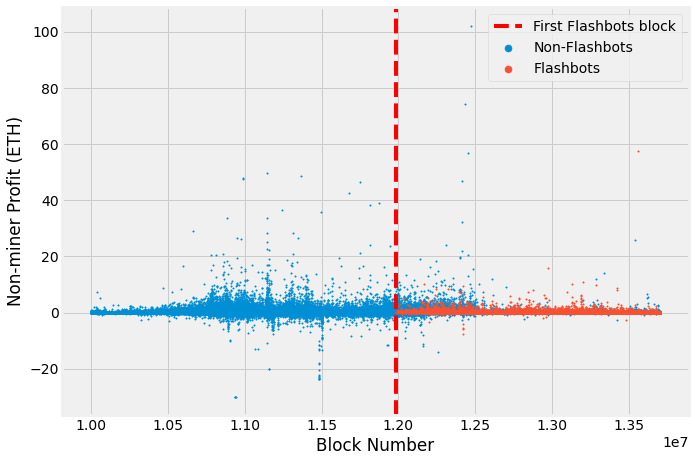

In [17]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(7)

non_fb_after_df = pd.DataFrame(list(confirmed_mevs.find(is_non_flashbots_query, {"block_number":1, "profit_eth":1})))
fb_after_df = pd.DataFrame(list(confirmed_mevs.find(is_fb_after_fb_query, {"block_number":1, "profit_eth":1})))
ax.scatter(non_fb_after_df.block_number, non_fb_after_df.profit_eth, s=2)
ax.scatter(fb_after_df.block_number, fb_after_df.profit_eth, s=2)
plt.xlabel("Block Number")
plt.ylabel("Non-miner Profit (ETH)")
plt.axvline(x=first_flashbots_block, color='red', linestyle='--')

ax.legend(labels=["First Flashbots block", "Non-Flashbots", "Flashbots"], markerscale=5.0)


This plot shows the profits of both Flashbots and non-Flashbots transactions
since the beginning of our measurements. Interestingly, we see that
non-Flashbots transactions have a less predictable payoff, and frequently return
negative profit.

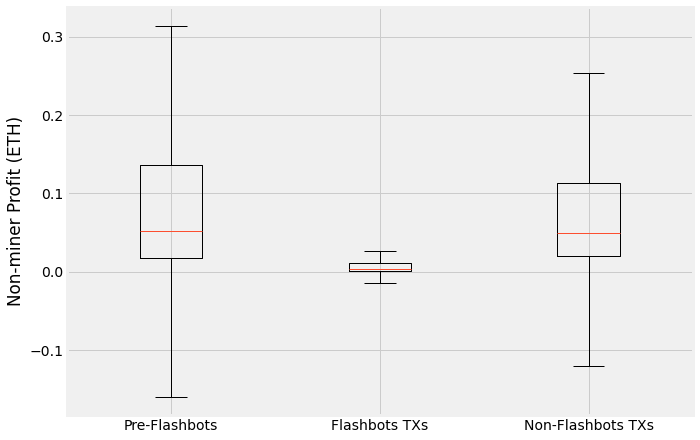

In [18]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(7)

non_fb_before_profits_df = pd.DataFrame(list(confirmed_mevs.find(non_fb_before_query, {"profit_eth":1})))
non_fb_after_profits_df = pd.DataFrame(list(confirmed_mevs.find(non_fb_after_query, {"profit_eth":1})))

ind_profits = [non_fb_before_profits_df.profit_eth, fb_after_df.profit_eth, non_fb_after_profits_df.profit_eth]
ind_profit_labels = ["Pre-Flashbots", "Flashbots TXs", "Non-Flashbots TXs"]

plt.boxplot(x=ind_profits, notch=False, sym='', labels=ind_profit_labels)
plt.ylabel("Non-miner Profit (ETH)")
plt.show() 

Variance is much lower for Flashbots transactions, but so is the average profit.

### Miner profits

Below we show how much miners are making pre- and post-Flashbots.

In [19]:
def make_miner_profit_pipline(match_query):
    sum_profit_operation = {
        "_id": None,
        "profit" : {"$sum": "$cost_eth"}
    }

    return make_pipeline(match_query, sum_profit_operation)


def calculate_miner_profit(match):
    return confirmed_mevs.aggregate(make_miner_profit_pipline(match)).next()["profit"]


In [64]:
non_fb_txs = pd.DataFrame(list(confirmed_mevs.find(is_non_flashbots_query, {"block_timestamp":1, "block_number":1, "cost_eth":1, "profit_eth":1})))
fb_miner_after_df = pd.DataFrame(list(confirmed_mevs.find(is_fb_after_fb_query, {"block_timestamp":1, "block_number":1, "cost_eth":1, "profit_eth":1})))

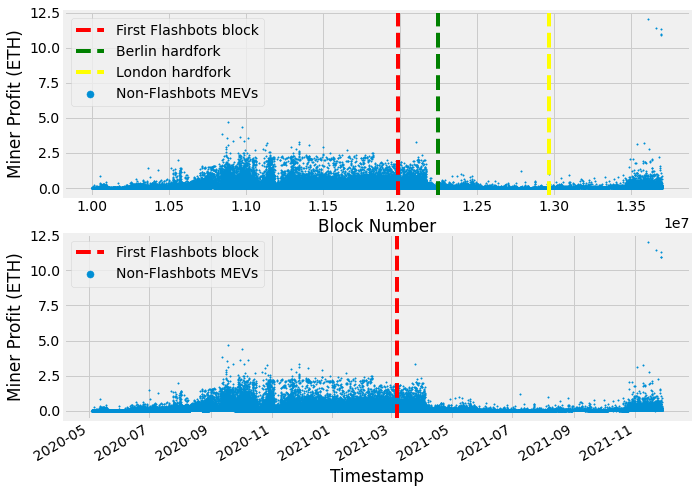

In [65]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(2, 1, figsize=(10, 7))

fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(7)

ax[0].scatter(non_fb_txs.block_number, non_fb_txs.cost_eth, s=2)

ax[0].set_xlabel("Block Number")
ax[0].set_ylabel("Miner Profit (ETH)")
ax[0].axvline(x=first_flashbots_block, color='red', linestyle='--')
ax[0].axvline(x=12244000, color='green', linestyle='--')
ax[0].axvline(x=12965000, color='yellow', linestyle='--')

ax[0].legend(labels=["First Flashbots block", "Berlin hardfork", "London hardfork", "Non-Flashbots MEVs"], markerscale=5.0)


ax[1].scatter(pd.to_datetime(non_fb_txs.block_timestamp, unit = 's'), non_fb_txs.cost_eth, s=2)

ax[1].set_xlabel("Timestamp")
ax[1].set_ylabel("Miner Profit (ETH)")
ax[1].axvline(x=pd.to_datetime(first_flashbots_block_raw["block_timestamp"], unit='s'), color='red', linestyle='--')

ax[1].legend(labels=["First Flashbots block", "Non-Flashbots MEVs"], markerscale=5.0)

for label in ax[1].get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')


This plot is showing the miner profits for non-Flashbots transactions. There is
an anomaly in the post-Flashbots epoch. **Why is it there?**

In [62]:
def avg_non_miner_cost_calc():
    match = is_fb_after_fb_query
    group = {"_id": "$block_number", "Avg": {"$avg": "$cost_eth"}}
    sort_op = {"_id": 1}
    pipeline = make_sorted_pipeline(match, group, sort_op)
    return pd.DataFrame(list(confirmed_mevs.aggregate(pipeline)))

avg_non_miner_cost = avg_non_miner_cost_calc()

/nix/store/h2h07bs2j44pvvbqv5h6cv8s9vamlh1f-python3.9-ipython-7.28.0/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


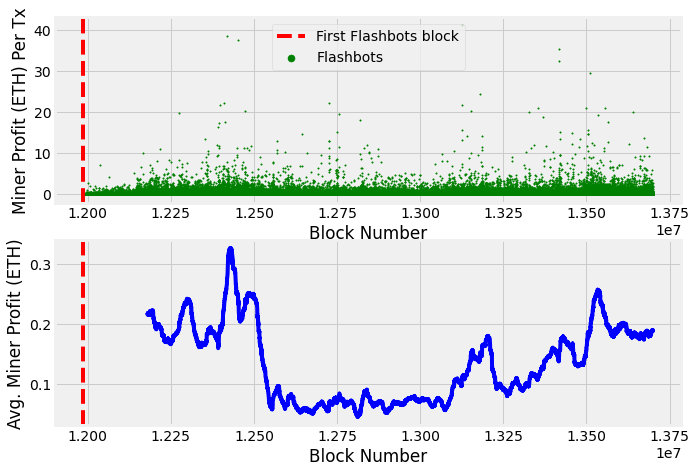

In [63]:

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(7)

ax[0].scatter(fb_miner_after_df.block_number, fb_miner_after_df.cost_eth, s=2, color='green')
ax[0].axvline(x=first_flashbots_block, color='red', linestyle='--')

# _id is block_number
blocks_per_day = 6446
ax[1].plot(avg_non_miner_cost._id, avg_non_miner_cost.Avg.rolling(blocks_per_day).mean(), color='blue')
ax[1].axvline(x=first_flashbots_block, color='red', linestyle='--')


#ax.scatter(non_fb_miner_after_df.block_number, non_fb_miner_after_df.cost_eth, s=2)
ax[0].set_xlabel("Block Number")
ax[0].set_ylabel("Miner Profit (ETH) Per Tx")
ax[1].set_xlabel("Block Number")
ax[1].set_ylabel("Avg. Miner Profit (ETH)")


#plt.axvline(x=first_flashbots_block, color='red', linestyle='--')

#plt.yscale('log')
#print(fb_after)
ax[0].legend(labels=["First Flashbots block", "Flashbots"], markerscale=5.0)

plt.show()

We next show how per-transaction profits compare between miners and searchers.

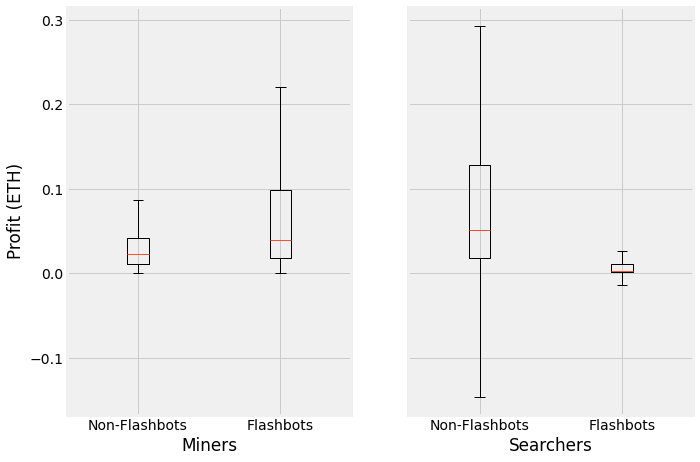

In [50]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1, 2, figsize=(10, 7), sharey=True)
fig.patch.set_facecolor('white')

miner_profits = [non_fb_miner_after_df.cost_eth, fb_miner_after_df.cost_eth]
searcher_profits = [non_fb_miner_after_df.profit_eth, fb_miner_after_df.profit_eth]
profit_labels = ["Non-Flashbots", "Flashbots"]

ax[0].boxplot(x=miner_profits, notch=False, sym='', labels=profit_labels)
ax[1].boxplot(x=searcher_profits, notch=False, sym='', labels=profit_labels)

ax[0].set_ylabel("Profit (ETH)")
ax[0].set_xlabel("Miners")
ax[1].set_xlabel("Searchers")

plt.show()

This plot shows that miners are seeing slightly higher profits when using
Flashbots than without Flashbots. This comes at the cost of somewhat increased
variance. Conversely, searchers (or in the non-Flashbots case: non-miners) see
lower profit, but lower variance. Since the average profit is the _expected_
profit, we can infer that searchers are only participating in Flashbots because
miners are participating. 

## Gas price variation

It is possible that Flashbots would cause the gas pricing dynamics to change. As such, we will plot the gas prices over time to discern any patterns.

In [78]:
#non_fb_txs_raw = pd.DataFrame(list(confirmed_mevs.find(is_non_flashbots_query, {"first_transaction.gasPrice":1, "second_transaction.gasPrice":1, "block_number":1, "cost_eth":1, "profit_eth":1})))
def gas_price_extraction_pipeline():
    return [
        {
            "$match":is_non_flashbots_query
        },
        #{
       #     "$group": {"_id": "$block_number", "Avg": {"$avg": "$gasPrice"}}
      #  },
     #       group = 
    #sort_op = {"_id": 1}
        {
            "$project": {
                "block_number": "$block_number",
                "gasPrice": "$first_transaction.gasPrice",
                "gasPrice": "$second_transaction.gasPrice"
            }
        },
        {
            "$unwind"
        }
    ]

pipeline1 = gas_price_extraction_pipeline("$first_transaction.gasPrice")
#pipeline2 = gas_price_extraction_pipeline("$second_transaction.gasPrice")

non_fb_txs_raw1 = pd.DataFrame(list(confirmed_mevs.aggregate(pipeline1)))
non_fb_txs_raw1
#non_fb_txs_raw2 = pd.DataFrame(list(confirmed_mevs.aggregate(pipeline2)))

#non_fb_txs_raw = pd.concat([non_fb_txs_raw1, non_fb_txs_raw2], ignore_index=True)
#non_fb_txs_raw

,_id,block_number,gasPrice
0,61bb7533201de9accdbb9109,10322101,67500000000
1,61bb75333f37a9fadbbb910a,10421210,51904122427
2,61bb7533ec0411d384bb9109,10206475,72500000000
3,61bb7533994f3d4b03bb910a,10090850,45600879565
4,61bb753316eaf6510bbb910b,10363398,58500000000
...,...,...,...
1032799,61bb95a5206c0426cfbc33c4,13691550,1387530535450
1032800,61bb95ac206c0426cfbc3407,13691607,957555345621
1032801,61bb95b6206c0426cfbc3456,13691673,124300000000
1032802,61bb95b5206c0426cfbc3448,13691661,327485254101


# Anomalies
A number of transactions in the Flashbots epoch yielded negative profit for
searchers which should not happen. A searcher standing to make negative profit
would not forward such a bundle to a miner. Here we explore those transactions
in depth.

In [51]:


unprofitable_fb_count = confirmed_mevs.count_documents(unprofitable_fb_query)
print(f"""In the Flashbots epoch, there have been {unprofitable_fb_count} unprofitable MEVs out of a total of {flashbots_txs} transactions. About {unprofitable_fb_count/flashbots_txs * 100:.2f}%.""")

def sum_unprofitable(currency):
    match = is_fb_after_fb_query | unprofitable_tx_query
    group = {"_id": f"profit_{currency}", "Sum": {"$sum": f"$profit_{currency}"}}
    pipeline = make_pipeline(match, group)
    return list(confirmed_mevs.aggregate(pipeline))[0]['Sum']
    
def sum_unprofitable_eth():
    return sum_unprofitable("eth")

def sum_unprofitable_usd():
    return sum_unprofitable("usd")

print(f"Unprofitable transactions in Flashbots total {-1*sum_unprofitable_eth():.2f} ETH or {locale.currency(-1*sum_unprofitable_usd(), grouping=True)} (USD).")

In the Flashbots epoch, there have been 6281 unprofitable MEVs out of a total of 410381 transactions. About 1.53%.
Unprofitable transactions in Flashbots total 68.04 ETH or $224,662.49 (USD).


In [52]:
pprint(list(confirmed_mevs.find(unprofitable_fb_query).sort("block_number", ASCENDING).limit(2)))

[{'_id': ObjectId('61bb866216eaf6510bbbf7bd'),
  'block_number': 12021015,
  'block_timestamp': 1615515848,
  'bot_address': '0xf8f50c9f86D9B6a5C612Ce3d05508a242cB079cd',
  'cost_eth': 0.12906520323961468,
  'cost_usd': 235.6804793719564,
  'eth_usd_price': 1826.0574768119818,
  'exchange_address': '0x4Dd26482738bE6C06C31467a19dcdA9AD781e8C4',
  'exchange_name': 'Uniswap V2',
  'first_transaction': {'from': '0x0000000023152Fb76626201d30577Eea74f26dBe',
                        'gas': 1500000,
                        'gasPrice': 0,
                        'hash': '0x067ec00d2c898baeecaa683983c2142a6ff4e060ff128f27a985faead7461807',
                        'input': '0x000006e10000000000000000000000000000000000000000000000005f7042ac62ef68a40000000000000000000000000b38210ea11411557c13457d4da7dc6ea731b88a0000000000000000000000004dd26482738be6c06c31467a19dcda9ad781e8c4',
                        'nonce': 3,
                        'to': '0xf8f50c9f86D9B6a5C612Ce3d05508a242cB079cd',
           

**Question for Christof**: in the above two insertions, both are using the same
exchange (Uniswap V2), but have different `exchange_address`es. Why is that?

**Answer**: This is probably okay. Not only will each token have its own exchange address, but the addresses themselves may change over time as the code is updated.

In [53]:
cdf_xlabels = {
    "exchange_address": "Exchange addresses", 
    "flashbots_miner": "Flashbots miners",
    "bot_address": "Bot addresses",
    "token_address": "Token addresses",
    "first_transaction.to": "Contract addresses",
}


def plot_cdf(data, ax, bins, xname, xmin=None, xmax=None, more_label=""):
    ax.hist(data, bins=bins, cumulative=True, histtype='step', density=True, linewidth=2)
    ax.set_xlim(xmin=xmin, xmax=xmax)
    ax.set_xlabel(cdf_xlabels[xname] + more_label)
    
    
def count_anomalies(anomaly_name, bins, ax1, ax2, xmin1=None, xmin2=None, xmax1=None, xmax2=None):
    match = is_fb_after_fb_query | unprofitable_tx_query
    group = {"_id": f"${anomaly_name}", "Counts": {"$sum": 1}}
    pipeline = make_pipeline(match, group)
    anomaly_counts = pd.DataFrame(list(confirmed_mevs.aggregate(pipeline)))
    plot_cdf(anomaly_counts.Counts, ax1, bins, anomaly_name, xmin=xmin1, xmax=xmax1, more_label=" (unprofitable)")
    
    all_pipeline = make_pipeline(is_fb_after_fb_query, group)
    all_counts = pd.DataFrame(list(confirmed_mevs.aggregate(all_pipeline)))
    plot_cdf(all_counts.Counts, ax2, bins, anomaly_name, xmin=xmin2, xmax=xmax2, more_label=" (all)")

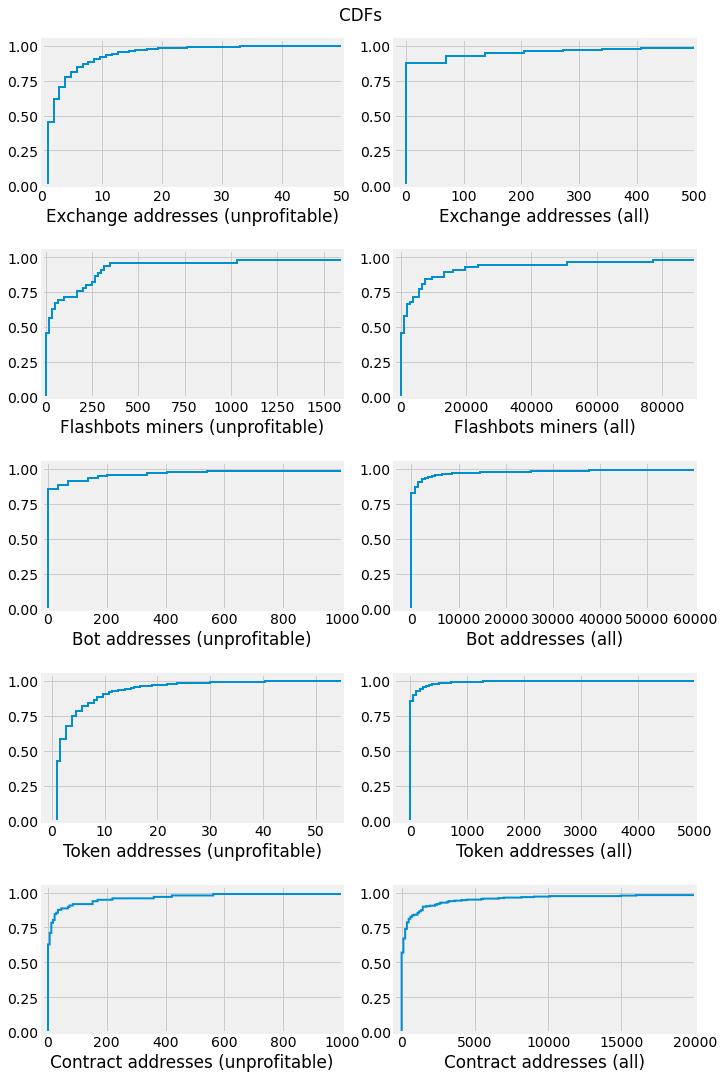

In [54]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(5,2)
fig.patch.set_facecolor('white')
fig.set_figwidth(10)
fig.set_figheight(15)

fig.suptitle("CDFs")
fig.tight_layout(h_pad=3)

count_anomalies("exchange_address", 60, ax[0, 0], ax[0, 1], xmin1=0, xmin2=-20, xmax1=50, xmax2=500)
count_anomalies("flashbots_miner", 100, ax[1, 0], ax[1, 1], xmin1=-20, xmin2=-2000, xmax1=1600, xmax2=90000)
count_anomalies("bot_address", 100, ax[2, 0], ax[2, 1], xmin1=-20, xmin2=None, xmax1=1000, xmax2=60000)
count_anomalies("token_address", 100, ax[3, 0], ax[3, 1], xmin1=None, xmin2=None, xmax1=55, xmax2=5000)
count_anomalies("first_transaction.to", 600, ax[4, 0], ax[4, 1], xmin1=-20, xmin2=-500, xmax1=1000, xmax2=20000)

The above plots show CDFs of the frequency of various attributes of MEV transactions. The left column represents the CDF of only *unprofitable* transactions, while the right column includes *all* MEV transaction. We will discuss them one row at a time.

1. This represents the frequency of specific exchange addresses. We see in the right plot that more than ~90% of MEV transactions were conducted on less than ~5-10 exchanges. On the left we see that some exchanges are involved in more unprofitable MEVs than others, but there is not enough evidence to claim this is anything beyond some exchanges are simply involved in more tranactions.
2. We see a similar story for the Flashbots miners. Not enough evidence to claim this is anything beyond some miners are mining more unprofitable MEVs because they have more mining power and are mining more of everything.
3. Same story.
4. Same story.
5. Same story.

# Open questions
- How diverse is the Flashbots user base? Is it just a few miners reaping most
  of the rewards? Or are a lot of people participating?

# Questions from meeting
- Can we infer Flashbots transactions? A heuristic? Is it worth the effor?